In [47]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 7]
%config InlineBackend.figure_format = 'retina'

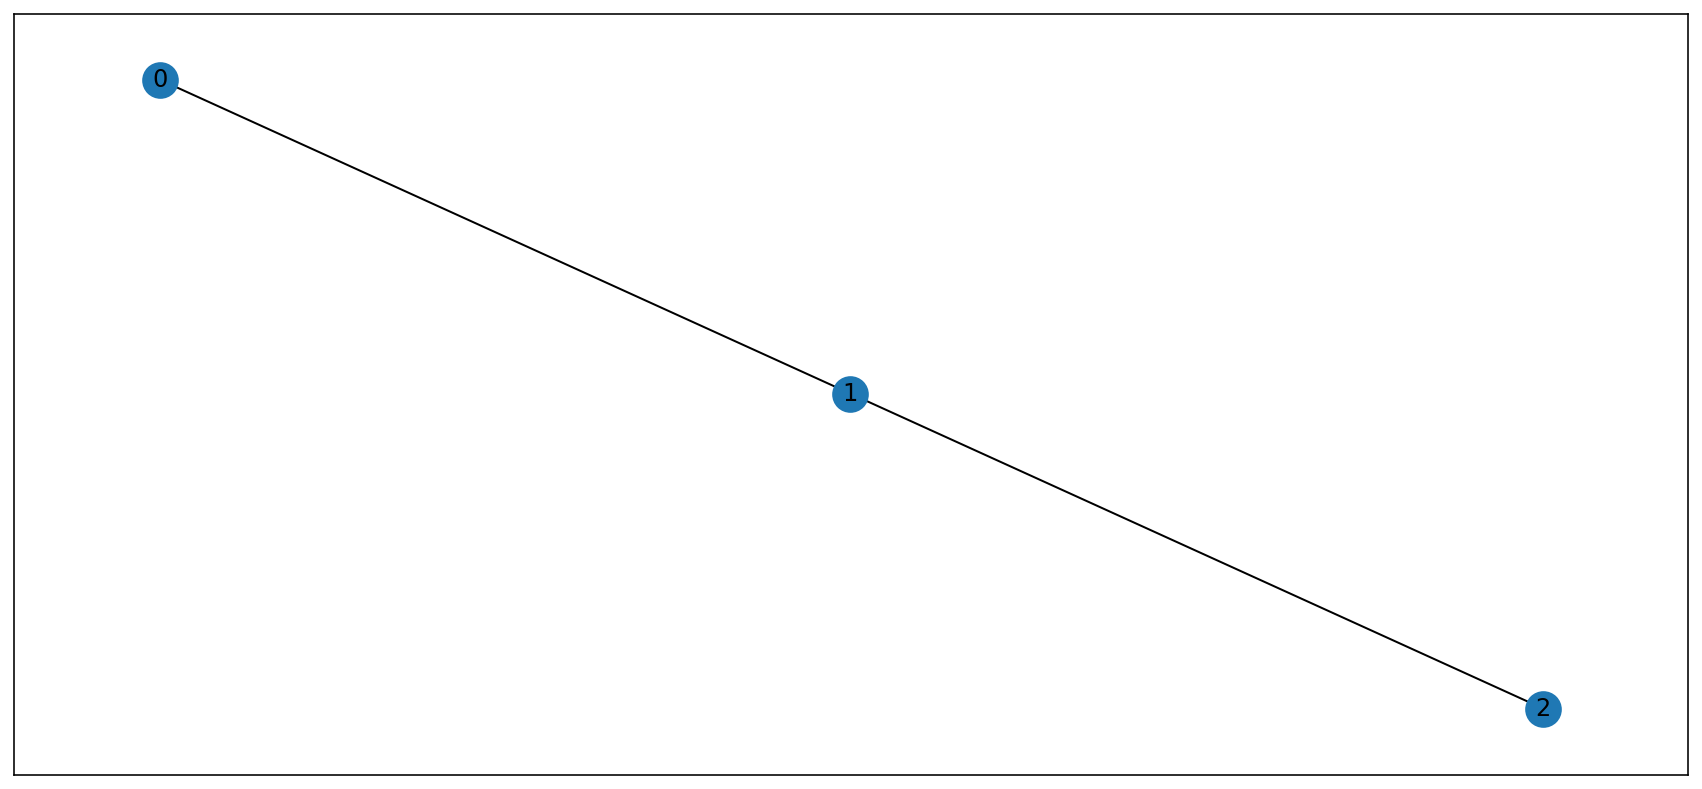

In [48]:
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2])
graph.add_edges_from([(0, 1), (1, 2)])

nx.draw_networkx(graph)

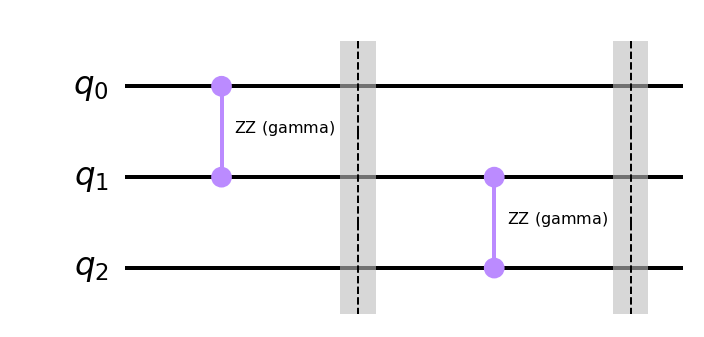

In [49]:
def problem_circuit(graph, gamma):
    qc_p = QuantumCircuit(len(graph.nodes()))
    
    for edge in list(graph.edges()):
        qc_p.rzz(gamma, edge[0], edge[1])
        qc_p.barrier()
        
    return qc_p

gamma = Parameter("gamma")
qc_p = problem_circuit(graph, gamma)
qc_p.draw('mpl')

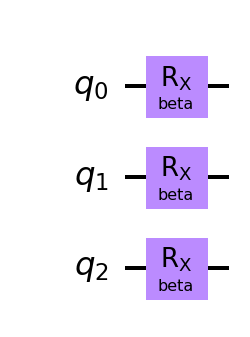

In [50]:
def ansatz_circuit(graph, beta):
    qc_p = QuantumCircuit(len(graph.nodes()))
    
    for i in list(graph.nodes()):
        qc_p.rx(beta, i)
        
    return qc_p

beta = Parameter("beta")
qc_p = ansatz_circuit(graph, beta)
qc_p.draw('mpl')

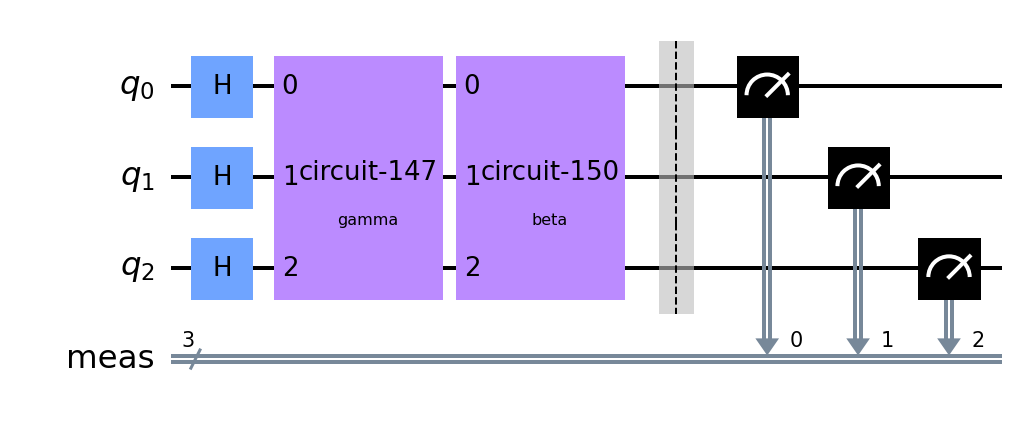

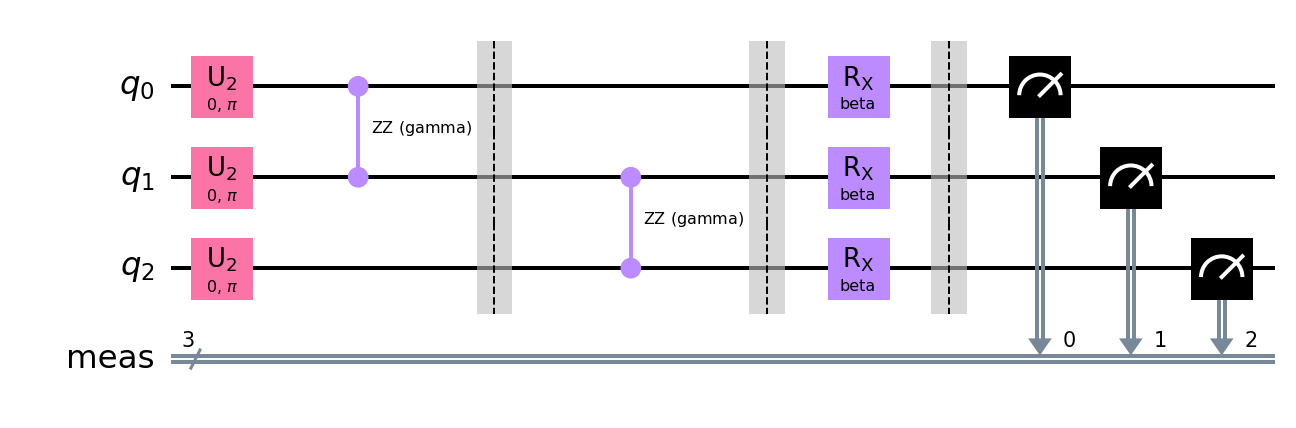

In [51]:
def get_circuit(graph, beta, gamma):
    cnt_qubits = len(graph.nodes())
    
    qc_qaoa = QuantumCircuit(cnt_qubits)
    
    # initial state
    qc_qaoa.h(range(cnt_qubits))
    
    # append problem circuit
    qc_qaoa.append(problem_circuit(graph, gamma), range(cnt_qubits))
    
    # append ansatz circuit
    qc_qaoa.append(ansatz_circuit(graph, beta), range(cnt_qubits))
    
    qc_qaoa.measure_all()
    return qc_qaoa

gamma = Parameter("gamma")
beta = Parameter("beta")
circ = get_circuit(graph, beta, gamma)

display(circ.draw('mpl'))
display(circ.decompose().draw('mpl'))

In [54]:
def get_expectation(counts, graph):
    avg = 0
    sum_count = 0
    
    for solution, count in counts.items():
        performance = 0
        for i, j in graph.edges():
            if solution[i] != solution[j]:
                performance -= 1
                
        avg += performance * count
        sum_count += count
        
    return avg/sum_count

In [55]:
def execute_circuit(graph, beta, gamma, backend, shots):
    qc = get_circuit(graph, beta, gamma)
    result = execute(qc, backend, shots = shots).result()
    
    return get_expectation(result.get_counts(), graph)

def qaoa(graph):
    backend = Aer.get_backend('qasm_simulator')
    
    result = minimize(
        lambda thetas: execute_circuit(graph, thetas[0], thetas[1], backend, 1024),
        [1.0, 1.0], # initial values
        method = 'COBYLA'
    )
    
    return result

result = qaoa(graph)
print(result)

     fun: -1.6640625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([2.36518163, 0.92222333])


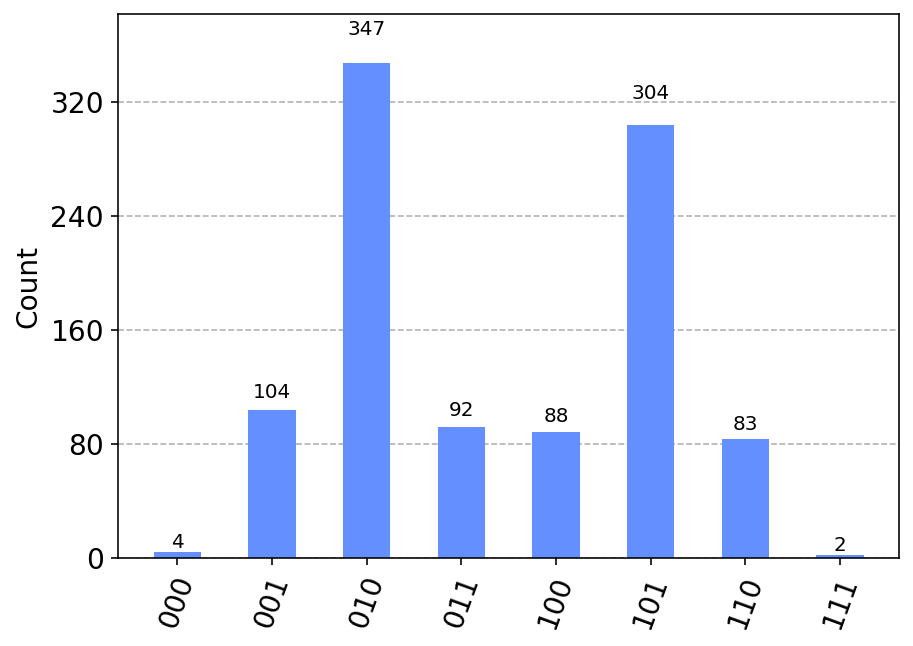

In [56]:
qc_res = get_circuit(graph, result.x[0], result.x[1])
counts =  execute(qc_res, Aer.get_backend('qasm_simulator'), shots = 1024).result().get_counts()
plot_histogram(counts)

## QAOA with qiskit

In [82]:
import pandas as pd
import networkx as nx
from qiskit_optimization.applications import Maxcut
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [67]:
data = pd.read_csv("./datasets/heroes/hero-network.csv")

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [69]:
data.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [70]:
heroes = [
 'MEDUSA/MEDUSALITH AM',
 'ARCLIGHT/PHILLIPA SO',
 'WOLVERINE/LOGAN ',
 'SCARLET WITCH/WANDA ',
 'ARAGORN',
 'OVERMIND/GROM',
 'BATTLEAXE/',
 'ION/',
 'PINK PEARL/'
]

In [72]:
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis = 1), columns = relations.columns).drop_duplicates(subset = ['hero1', 'hero2'])

In [73]:
graph = nx.from_pandas_edgelist(relations, source = 'hero1', target = 'hero2')

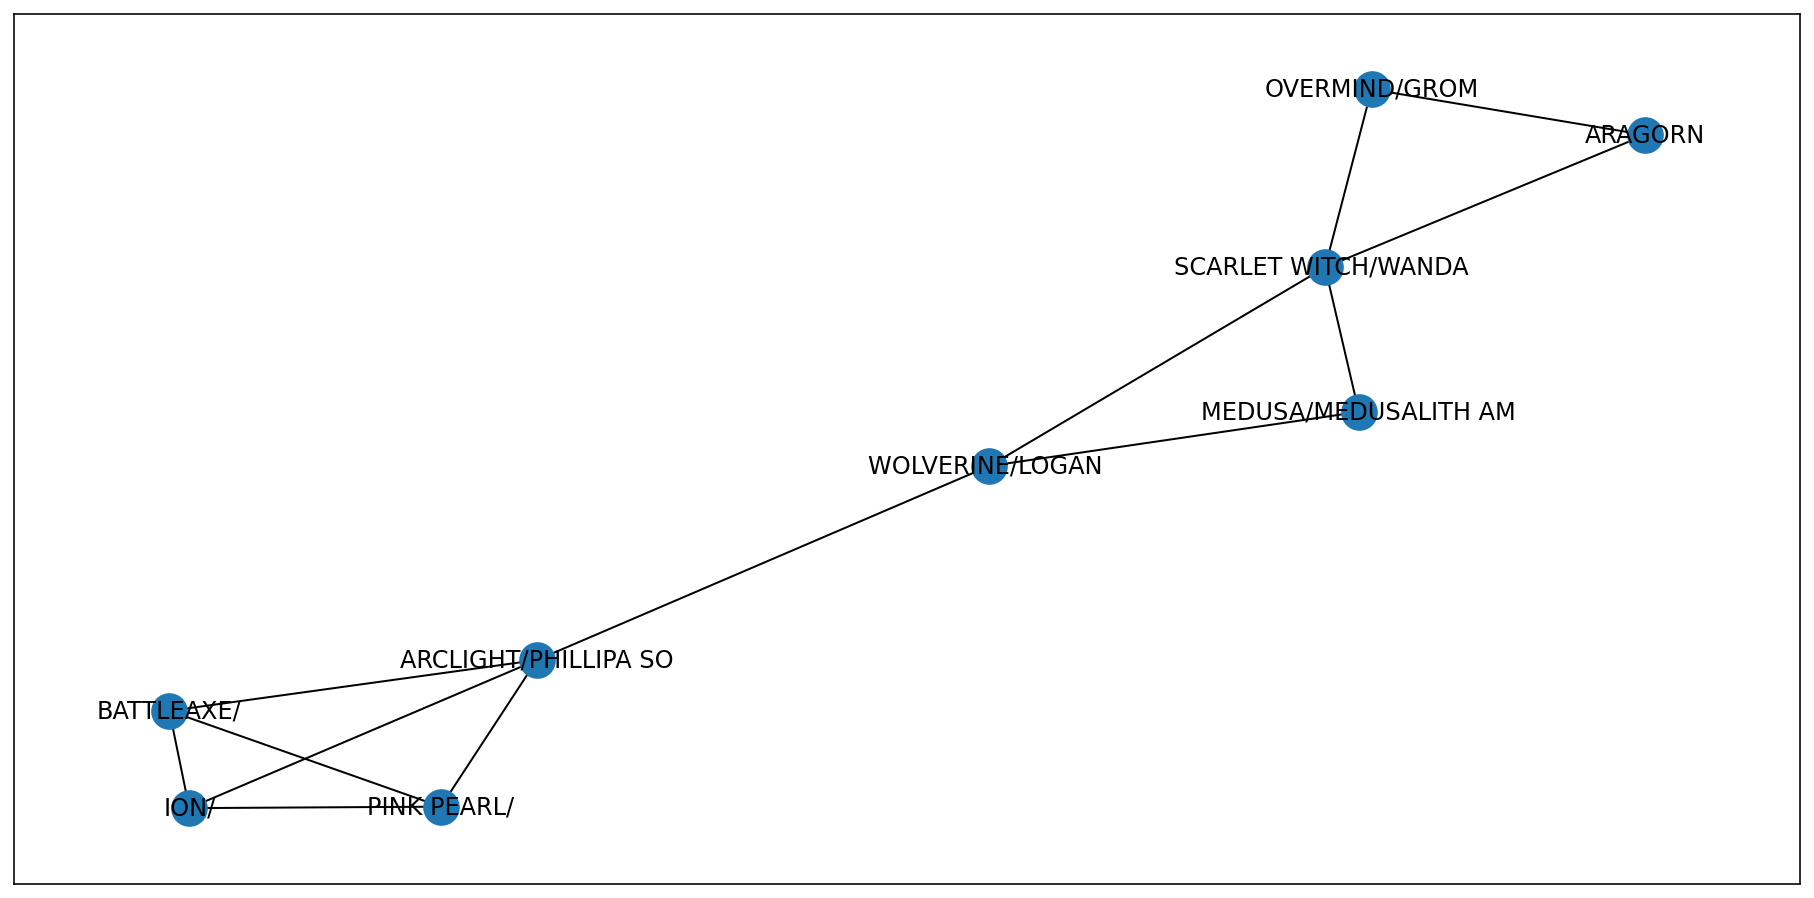

In [74]:
plt.figure(1, figsize = (16, 8))
nx.draw_networkx(graph)

In [76]:
matrix = nx.to_pandas_adjacency(graph, dtype = int)
adjacency = matrix.to_numpy()

In [79]:
max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

In [80]:
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

In [86]:
qaoa = QAOA(quantum_instance = quantum_instance)
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

result = qaoa_optimizer.solve(qp)

In [118]:
print('optimal function value:', result.fval)
print('optimal value:', result.x)
print('status:', str(result.status).replace('OptimizationResultStatus.', ''))

optimal function value: 9.0
optimal value: [1. 0. 0. 0. 0. 1. 1. 0. 0.]
status: SUCCESS


## Weighted max-cut

In [120]:
data = pd.read_csv("./datasets/heroes/hero-network.csv")

count_series1 = data.groupby(['hero1']).size()
count_series2 = data.groupby(['hero2']).size()

In [122]:
appearances = count_series1.add(count_series2, fill_value = 0)
appearances = appearances.sort_values(ascending = False)
appearances

CAPTAIN AMERICA         16499.0
SPIDER-MAN/PETER PAR    13717.0
IRON MAN/TONY STARK     11817.0
THOR/DR. DONALD BLAK    11427.0
THING/BENJAMIN J. GR    10681.0
                         ...   
VINDIKTOR/                  1.0
SHAW, MILDRED               1.0
RIPPER/DR. JACQUELIN        1.0
QUASAR                      1.0
GREASE                      1.0
Length: 6426, dtype: float64

In [125]:
n = 12
topheroes = appearances[:n].keys().to_list()
topheroes

['CAPTAIN AMERICA',
 'SPIDER-MAN/PETER PAR',
 'IRON MAN/TONY STARK ',
 'THOR/DR. DONALD BLAK',
 'THING/BENJAMIN J. GR',
 'WOLVERINE/LOGAN ',
 'HUMAN TORCH/JOHNNY S',
 'SCARLET WITCH/WANDA ',
 'MR. FANTASTIC/REED R',
 'VISION ',
 'INVISIBLE WOMAN/SUE ',
 'BEAST/HENRY &HANK& P']

In [130]:
relations = data[(data.hero1.isin(topheroes)) & (data.hero2.isin(topheroes))]

In [133]:
grouped_relations = relations.groupby(['hero1', 'hero2']).size().reset_index().rename(columns = {0: 'count'})
grouped_relations.head()

,hero1,hero2,count
0,BEAST/HENRY &HANK& P,CAPTAIN AMERICA,92
1,BEAST/HENRY &HANK& P,HUMAN TORCH/JOHNNY S,31
2,BEAST/HENRY &HANK& P,INVISIBLE WOMAN/SUE,25
3,BEAST/HENRY &HANK& P,IRON MAN/TONY STARK,76
4,BEAST/HENRY &HANK& P,MR. FANTASTIC/REED R,29


In [137]:
grouped_relations.loc[
    (grouped_relations['hero1'] == 'CAPTAIN AMERICA') & (grouped_relations['hero2'] == 'VISION ') |
    (grouped_relations['hero2'] == 'CAPTAIN AMERICA') & (grouped_relations['hero1'] == 'VISION ')
]

,hero1,hero2,count
21,CAPTAIN AMERICA,VISION,180
112,VISION,CAPTAIN AMERICA,205


In [139]:
relations['relation'] = [' - '.join(x) for x in np.sort(relations.to_numpy(), axis = 1)]

In [141]:
summed_relations = relations.groupby(['relation']).size().reset_index().rename(columns = {0: 'count'})
summed_relations

,relation,count
0,BEAST/HENRY &HANK& P - CAPTAIN AMERICA,169
1,BEAST/HENRY &HANK& P - HUMAN TORCH/JOHNNY S,57
2,BEAST/HENRY &HANK& P - INVISIBLE WOMAN/SUE,54
3,BEAST/HENRY &HANK& P - IRON MAN/TONY STARK,142
4,BEAST/HENRY &HANK& P - MR. FANTASTIC/REED R,60
...,...,...
62,THING/BENJAMIN J. GR - VISION,101
63,THING/BENJAMIN J. GR - WOLVERINE/LOGAN,76
64,THOR/DR. DONALD BLAK - VISION,255
65,THOR/DR. DONALD BLAK - WOLVERINE/LOGAN,28


In [142]:
summed_relations.loc[
    (summed_relations['relation'] == 'CAPTAIN AMERICA - VISION ') |
    (summed_relations['relation'] == 'VISION - CAPTAIN AMERICA')
]

,relation,count
20,CAPTAIN AMERICA - VISION,385


In [144]:
summed_relations = pd.merge(summed_relations, relations, on = 'relation', how = 'right')

In [147]:
sub_graph = nx.from_pandas_edgelist(summed_relations, source = 'hero1', target = 'hero2', edge_attr = 'count')

print(nx.info(sub_graph))
print('Network density:', nx.density(sub_graph))

Graph with 12 nodes and 67 edges
Network density: 1.0151515151515151


In [149]:
summed_relations.drop(summed_relations[summed_relations['hero1'] == summed_relations['hero2']].index, inplace = True)

In [150]:
sub_graph = nx.from_pandas_edgelist(summed_relations, source = 'hero1', target = 'hero2', edge_attr = 'count')

print(nx.info(sub_graph))
print('Network density:', nx.density(sub_graph))

Graph with 12 nodes and 66 edges
Network density: 1.0


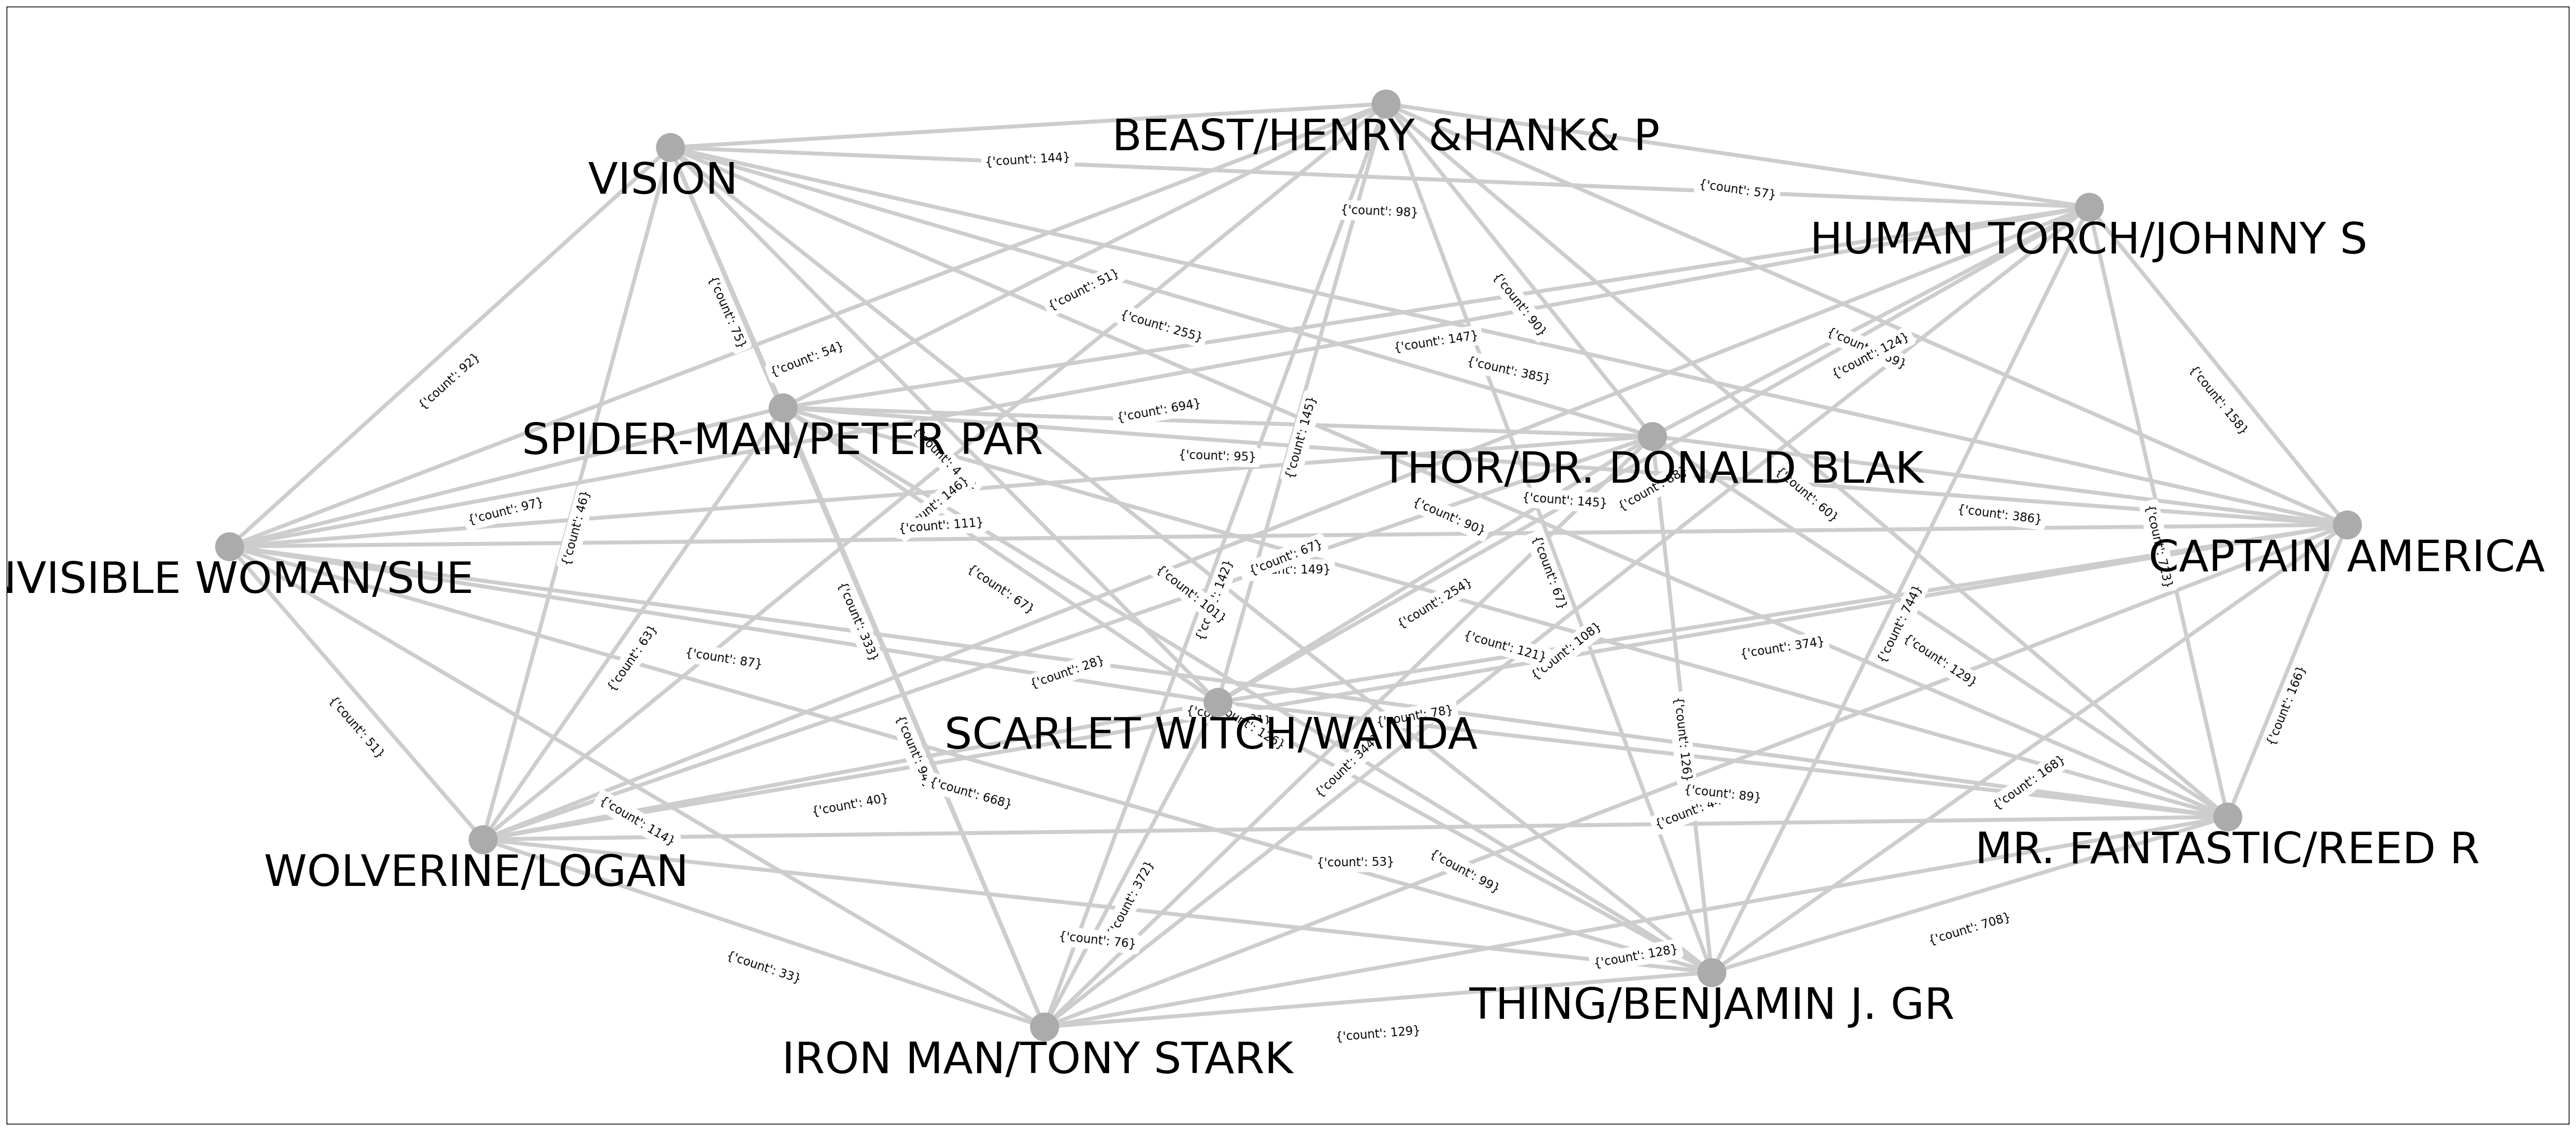

In [165]:
plt.figure(1, figsize = (12, 2.5))
plt.tight_layout()
plt.subplots_adjust(bottom = -5.4, right = 1.5, left = -1.5)

def place_labels(pos, x_shift, y_shift):
    return {n: (x + x_shift, y + y_shift) for n, (x, y) in pos.items()}

pos = nx.spring_layout(sub_graph)
pos_nodes = place_labels(pos, 0 , -0.07)

nx.draw_networkx_nodes(sub_graph, pos = pos, node_color = '#ABABAB', node_size = 800)
nx.draw_networkx_edges(sub_graph, pos = pos, width = 4, edge_color = "#CDCDCD")

labels = nx.draw_networkx_edge_labels(sub_graph, pos = pos_nodes, font_color = "#000000", font_size = 12)
labels = nx.draw_networkx_labels(sub_graph, pos = pos_nodes, font_color = "#000000", font_size = 44)

plt.show()

In [154]:
matrix = nx.to_pandas_adjacency(sub_graph, weight = 'count', dtype = int)
adjacency = matrix.to_numpy()
adjacency

array([[  0, 372, 142, 446,  33, 333, 128, 129, 114, 344,  94, 108],
       [372,   0, 145, 374,  40, 422,  89,  99,  87, 254,  67,  88],
       [142, 145,   0, 169, 146, 144,  60,  67,  54,  90,  51,  57],
       [446, 374, 169,   0,  78, 385, 166, 168, 149, 386, 145, 158],
       [ 33,  40, 146,  78,   0,  46,  53,  76,  51,  28,  63,  67],
       [333, 422, 144, 385,  46,   0,  90, 101,  92, 255,  75,  98],
       [128,  89,  60, 166,  53,  90,   0, 708, 701, 129, 121, 713],
       [129,  99,  67, 168,  76, 101, 708,   0, 668, 126, 126, 744],
       [114,  87,  54, 149,  51,  92, 701, 668,   0, 111,  97, 694],
       [344, 254,  90, 386,  28, 255, 129, 126, 111,   0,  95, 124],
       [ 94,  67,  51, 145,  63,  75, 121, 126,  97,  95,   0, 147],
       [108,  88,  57, 158,  67,  98, 713, 744, 694, 124, 147,   0]])

In [155]:
max_cut = Maxcut(adjacency)

qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()

In [156]:
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend)

In [157]:
qaoa = QAOA(quantum_instance = quantum_instance)
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

result = qaoa_optimizer.solve(qp)

In [158]:
print('optimal function value:', result.fval)
print('optimal value:', result.x)
print('status:', str(result.status).replace('OptimizationResultStatus.', ''))

optimal function value: 7765.0
optimal value: [0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]
status: SUCCESS
